<b><center><font size="4">WeatherMeteo Project </font></center></b>
<hr>

Developed by: Alexander Antonenko

<hr>

##### Project description:

We intend to gather meteorological data from a set of Portuguese cities as well as their distance to a reference city. The aim of this database is to gather information that will allow the application of a machine learning algorithm in the future to study the effect (if any) that the proximity of a city to the sea has on the local climate. For this purpose, it is intended to bring together a set of 10 cities with different distances from a reference coastal city. When choosing cities, mountainous cities should be left out in order to avoid the introduction of other factors that could affect the climate (namely altitude). You must collect meteorological data every 1 hour for 5 consecutive days.

<hr>


Import all necessary libraries:

In [477]:
import requests
import json
import pprint
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")

Cities marked on the map with labels were selected for analysis:

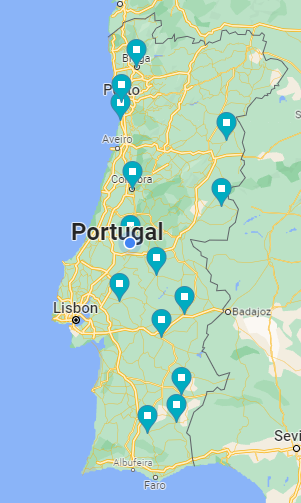

### 1. Using the API “Current Weather” (https://openweathermap.org/current) obtain the following weather data every hour during the space of 5 consecutive days:

- Temperature
- Humidity
- Pressure
- Description
- Wind speed
- Wind degree
- Timestamp (dt)


Having studied the API provided by "Current Weather” I realized that the task can be completed in 2 ways:

1. Parse the data immediately in 5 days;
2. Create an API that will receive data every hour and host it on a third-party server;

I have implemented both options.

```python
import requests
import json
import pprint
from datetime import datetime
import pandas as pd


ONE_DAY = 86400


class Weather:
    
    def __init__(self, first_date, cities_info, api_key):
        self.first_date = first_date
        self.cities_info = cities_info
        self.api_key = api_key

        
    def parse_data(self):
        weather_descriptions = []
        for city in self.cities_info.keys():

            for i in range(5):  
                parse_date = self.first_date + i * ONE_DAY

                url = f"https://api.openweathermap.org/data/2.5/onecall/timemachine?lat={self.cities_info[city]['lat']}&lon={self.cities_info[city]['lon']}&dt={parse_date}&appid={self.api_key}"

                r = requests.get(url)

                data = json.loads(r.text)
                for hour in  data['hourly']:
                    weather_descriptions.append({'city': city,
                                             'dt': hour['dt'], 
                                             'humidity': hour['humidity'], 
                                             'pressure': hour['pressure'],
                                             'description': hour['weather'][0]['description'],
                                             'wind_speed': hour['wind_speed'],
                                             'wind_deg': hour['wind_deg'],
                                             'temp': hour['temp']
                                            })
        return {'weather': weather_descriptions}


def create_json_file(weather_descriptions, file_name):
    with open(file_name, 'w') as f:
        json.dump(weather_descriptions, f)

        
def create_dataframe(file_name):
    with open(file_name, 'r') as file:
        file_data = json.load(file)

    return pd.DataFrame(file_data['weather'])


Import created package:

In [2]:
from Weather import *

Required variables and constants:

In [11]:
file_name = 'weather.json'
first_date = 1638230400 # Timestamp of November 30
APIKEY = '166172443c8228bd52834b23281d816b'

MAIN_CITY = 'Esmoriz'

cities_info = {
    'Ponte de Sor': {'lat': 39.2496, 'lon': -8.0101},
    'Tomar':  {'lat': 39.602, 'lon': -8.4092},
    'Coimbra': {'lat': 40.2056, 'lon': -8.4195},
    'Almodovar': {'lat': 37.4959, 'lon': -8.0937},
    'Pinhel': {'lat': 40.774, 'lon': -7.0668},
    'Monsanto': {'lat': 39.462, 'lon': -8.7118},
    'Porto': {'lat': 41.1496, 'lon': -8.611},
    'Evora': {'lat': 38.5667, 'lon': -7.9},
    'Serpa': {'lat': 37.9458, 'lon': -7.5975},
    'Mertola': {'lat': 37.6592, 'lon': -7.6643},
    'Estremoz': {'lat': 38.8443, 'lon': -7.5859},
    'Coruche': {'lat': 38.9595, 'lon': -8.5252},
    'Esmoriz': {'lat': 40.9577, 'lon': -8.6275},
    'Braga': {'lat': 41.5503, 'lon': -8.4201},
}

Create an object of the class and get the data

In [10]:
cities = Weather(first_date, cities_info, APIKEY)

weather_descriptions = cities.parse_data()

Example of the received data:

In [435]:
weather_descriptions['weather'][:2]

[{'city': 'Ponte de Sor',
  'dt': 1638230400,
  'humidity': 56,
  'pressure': 1027,
  'description': 'few clouds',
  'wind_speed': 2.11,
  'wind_deg': 98,
  'temp': 286.96},
 {'city': 'Ponte de Sor',
  'dt': 1638234000,
  'humidity': 56,
  'pressure': 1027,
  'description': 'few clouds',
  'wind_speed': 2.11,
  'wind_deg': 98,
  'temp': 286.96}]

Method 2 provides us with the absolutely similar result, but it requires a virtual machine running continuously for 5 days. At the output, we also get a json file, which we can then convert to a dataframe and work with it. The implementation code of the second method (do not run it once again, since its work will take 5 days):

```python
def write_json(new_data, filename='weather.json'):

    with open(filename,'r+') as file:
        file_data = json.load(file)

        file_data["weather"].append(new_data)

        file.seek(0)

        json.dump(file_data, file, indent = 4)


def call_weather_api(city):
    url = "https://api.openweathermap.org/data/2.5/weather?"
    payload = {'q': city, 'appid': '166172443c8228bd52834b23281d816b'}

    try:
        r = requests.get(url, params=payload)
        data = json.loads(r.text)
    except:
        print("Try to use another appid")
        payload = {'q': city, 'appid': '2e1e483d1dd6967290d6551fd5efcce5'}
        r = requests.get(url, params=payload)
        data = json.loads(r.text)

    main_information = {"city": city,
                        "dt": data['dt'],
                        "humidity": data['main']['humidity'],
                        "pressure": data['main']['pressure'],
                        "description": data['weather'][0]['description'],
                        "wind_speed": data['wind']['speed'],
                        "wind_deg": data['wind']['deg'],
                        "temp": data['main']['temp'],
                        "lat": data['coord']['lat'],
                        "lon": data['coord']['lon']
                       }

    write_json(main_information)


def parse_data_job():

    cities = ['Ponte de Sor', 'Tomar', 'Coimbra', 'Almodovar',
              'Pinhel','Monsanto', 'Porto', 'Evora', 'Serpa',
              'Mertola', 'Estremoz', 'Coruche', 'Esmoriz', 'Braga']

    for city in cities:
        call_weather_api(city)


for i in range(24*5):
    try:
        parse_data_job()
        print(f"Info for the {i+1} hour uploaded")
    except:
        try:
            print("Some problems, let's sleep")
            time.sleep(60)
            parse_data_job()
            print(f"Info for the {i+1} hour uploaded")
        except:
            time.sleep(60)
            print("Some more problems, let's sleep again")
            parse_data_job()
            print(f"Info for the {i+1} hour uploaded")

    time.sleep(3600)
```

To run this script I used this site https://www.pythonanywhere.com/ , which provides free virtual machines.

It is worth noting that the for loop with the time.sleep function was used, since the hosting on which I ran this script did not allow the apscheduler library to be installed. A similar code could be rewritten as follows:

```python
scheduler = BlockingScheduler()
scheduler.add_job(parse_data_job, 'interval', hour=1)
scheduler.start()
```

### 2. Use geocoding packages (e.g., “Geopy” (https://geopy.readthedocs.io/en/stable/) to obtain in a grammatical way the distance between the selected cities and the reference city.

Let's create a function for automatic calculation of distances between cities and calculate the distances from all cities to the main city (in our case, this is <b>Esmoriz</b>)

In [436]:
import geopy.distance


def calculate_distance(coords_1, coords_2):
    return round(geopy.distance.geodesic([coords_1['lat'], coords_1['lon']],
                                   [coords_2['lat'], coords_2['lon']]).km, 2)


for city_name in cities_info.keys():
    cities_info[city_name]['distance'] = calculate_distance(cities_info[MAIN_CITY], cities_info[city_name])

Get the following result:

In [437]:
cities_info

{'Ponte de Sor': {'lat': 39.2496, 'lon': -8.0101, 'distance': 196.83},
 'Tomar': {'lat': 39.602, 'lon': -8.4092, 'distance': 151.68},
 'Coimbra': {'lat': 40.2056, 'lon': -8.4195, 'distance': 85.35},
 'Almodovar': {'lat': 37.4959, 'lon': -8.0937, 'distance': 387.08},
 'Pinhel': {'lat': 40.774, 'lon': -7.0668, 'distance': 133.15},
 'Monsanto': {'lat': 39.462, 'lon': -8.7118, 'distance': 166.24},
 'Porto': {'lat': 41.1496, 'lon': -8.611, 'distance': 21.36},
 'Evora': {'lat': 38.5667, 'lon': -7.9, 'distance': 272.69},
 'Serpa': {'lat': 37.9458, 'lon': -7.5975, 'distance': 345.94},
 'Mertola': {'lat': 37.6592, 'lon': -7.6643, 'distance': 375.5},
 'Estremoz': {'lat': 38.8443, 'lon': -7.5859, 'distance': 250.99},
 'Coruche': {'lat': 38.9595, 'lon': -8.5252, 'distance': 222.04},
 'Esmoriz': {'lat': 40.9577, 'lon': -8.6275, 'distance': 0.0},
 'Braga': {'lat': 41.5503, 'lon': -8.4201, 'distance': 68.07}}

### 3. Save the obtained data in a single json file.

Create a json file based on the received data using a function from the package:

In [438]:
create_json_file(weather_descriptions, file_name)

### 4. List the data in a dataframe.

Forming a dataframe:

In [439]:
weather_df = create_dataframe(file_name)

The number of rows should be equal to 14 cities * 24 hours * 5 days = 1680. Let's check it out

In [440]:
weather_df.shape

(1680, 8)

Let's look at the resulting dataset:

In [441]:
weather_df.head(3)

,city,dt,humidity,pressure,description,wind_speed,wind_deg,temp
0,Ponte de Sor,1638230400,56,1027,few clouds,2.11,98,286.96
1,Ponte de Sor,1638234000,56,1027,few clouds,2.11,98,286.96
2,Ponte de Sor,1638237600,56,1027,few clouds,2.11,98,286.96


In [442]:
weather_df.tail(3)

,city,dt,humidity,pressure,description,wind_speed,wind_deg,temp
1677,Braga,1638651600,90,1028,clear sky,1.24,313,282.72
1678,Braga,1638655200,90,1028,few clouds,1.30,301,282.15
1679,Braga,1638658800,91,1028,scattered clouds,1.63,307,281.57


As a result of this step, we have a sample of weather data for the last 5 days in 14 cities in Portugal. Let's start their graphical analysis.

### 5. Carry out a graphical analysis of the results referring/justifying the results obtained.

#### 5.1. Check the temperature evolution on a given day in a city of your choice.

In order to conduct this research, it is worth converting the date a little into a format suitable for work:

In [443]:
weather_df['datetime'] = pd.to_datetime(weather_df['dt'].map(datetime.fromtimestamp))

We will get a sample of weather data for December 3 in Coimbra:

In [444]:
weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == 'Coimbra')]
weather_1day = weather_1day

Build a graph for the sample obtained above:

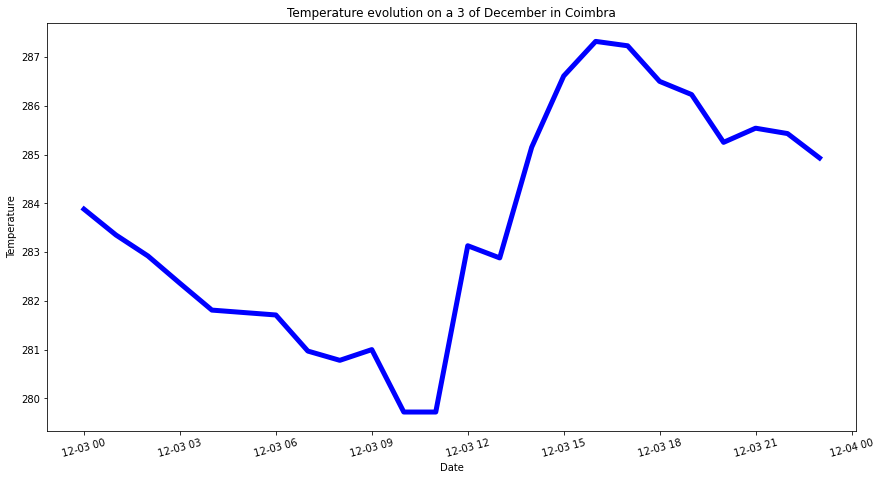

In [445]:
plt.plot(weather_1day['datetime'], weather_1day['temp'], linewidth=5.0, color='blue')
plt.xticks(rotation=15)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.gcf().set_size_inches(14.5, 7.5)
plt.title('Temperature evolution on a 3 of December in Coimbra')
plt.show()

From the graph we can see that the temperature is higher during the day than at night. The highest temperature is around 4-5 p.m., and the smallest is around 10-11 a.m.

### 5.2. Check the temperature evolution over the 5 days collected in a city of your choice.

Take the temperature data in Coimbra for the entire observation period (5 days) and visualize them

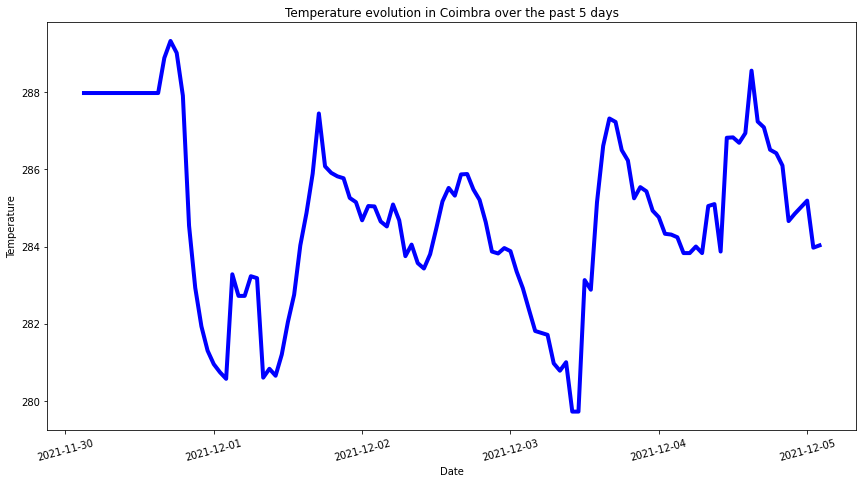

In [446]:
weather_5day = weather_df[weather_df['city'] == 'Coimbra']

plt.plot(weather_5day['datetime'], weather_5day['temp'], linewidth=4.0, color='blue')
plt.xticks(rotation=15)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.gcf().set_size_inches(14.5, 7.5)
plt.title('Temperature evolution in Coimbra over the past 5 days')
plt.show()

The graph shows that the temperature at night in Coimbra has increased from 2 to 3 of December, it is not yet clear what could have caused this jump, perhaps the API provided not entirely correct data. It is worth testing this hypothesis

Judging by the information on the website https://www.meteoblue.com/en/weather/historyclimate/weatherarchive/coimbra_portugal_2740637 the temperature really rose during this period. In this case, the hypothesis above is rejected.

Let's see how the temperature behaved during this period in other cities:

No handles with labels found to put in legend.


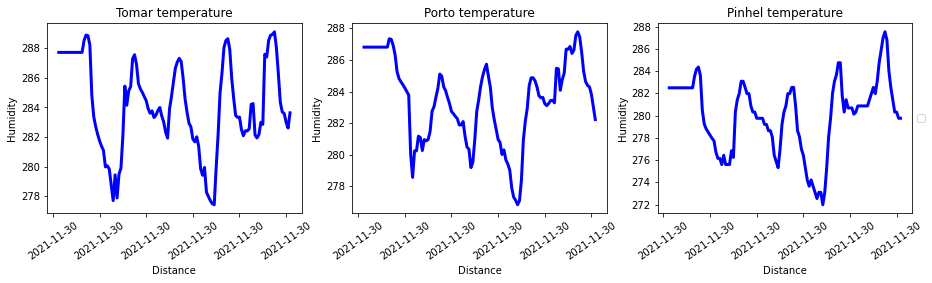

In [447]:
cities_check_list = ['Tomar','Porto', 'Pinhel']


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax_list = [ax1, ax2, ax3]

for city_name, ax in zip(cities_check_list, ax_list):
    weather_5day = weather_df[weather_df['city'] == city_name]
    weather_5day = weather_5day
    ax.plot(weather_5day['datetime'], weather_5day['temp'], linewidth=3.0, color = 'blue')

    ax.set(xlabel='Distance', ylabel='Humidity', title= city_name + ' temperature')
    ax.set_xticklabels(labels = weather_5day['datetime'].dt.date,rotation=35)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gcf().set_size_inches(15.5, 3.5)

plt.show()

From the graphs above, we see that temperature jumps occurred in all the selected cities - from this we conclude that there was no obvious anomaly in Mertola and the temperature increased throughout the country.

### 5.3. Check the temperature evolution on a given day in 6 cities of your choice. Since the objective is to analyze how and if the proximity to the sea influences the weather, you should start by choosing the 3 cities closest to the sea (in green in the example) and the 3 furthest away (in red in the example).

Based on the distances obtained above, we chose 3 cities closer to <b>Esmoriz</b> and away from it:

In [448]:
cities_info

{'Ponte de Sor': {'lat': 39.2496, 'lon': -8.0101, 'distance': 196.83},
 'Tomar': {'lat': 39.602, 'lon': -8.4092, 'distance': 151.68},
 'Coimbra': {'lat': 40.2056, 'lon': -8.4195, 'distance': 85.35},
 'Almodovar': {'lat': 37.4959, 'lon': -8.0937, 'distance': 387.08},
 'Pinhel': {'lat': 40.774, 'lon': -7.0668, 'distance': 133.15},
 'Monsanto': {'lat': 39.462, 'lon': -8.7118, 'distance': 166.24},
 'Porto': {'lat': 41.1496, 'lon': -8.611, 'distance': 21.36},
 'Evora': {'lat': 38.5667, 'lon': -7.9, 'distance': 272.69},
 'Serpa': {'lat': 37.9458, 'lon': -7.5975, 'distance': 345.94},
 'Mertola': {'lat': 37.6592, 'lon': -7.6643, 'distance': 375.5},
 'Estremoz': {'lat': 38.8443, 'lon': -7.5859, 'distance': 250.99},
 'Coruche': {'lat': 38.9595, 'lon': -8.5252, 'distance': 222.04},
 'Esmoriz': {'lat': 40.9577, 'lon': -8.6275, 'distance': 0.0},
 'Braga': {'lat': 41.5503, 'lon': -8.4201, 'distance': 68.07}}

In [449]:
cities_info.keys()

dict_keys(['Ponte de Sor', 'Tomar', 'Coimbra', 'Almodovar', 'Pinhel', 'Monsanto', 'Porto', 'Evora', 'Serpa', 'Mertola', 'Estremoz', 'Coruche', 'Esmoriz', 'Braga'])

In [450]:
not_far_from_main = ['Pinhel', 'Porto', 'Braga']
                     
far_from_main = ['Tomar','Coruche', 'Monsanto']

build temperature charts for December 3 for the cities selected above:

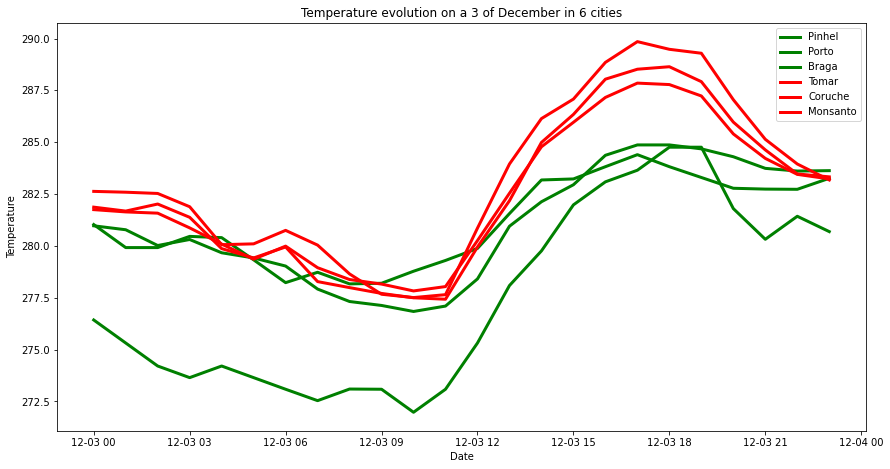

In [451]:
for city_name in not_far_from_main:
    weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == city_name)]
    plt.plot(weather_1day['datetime'], weather_1day['temp'], color='green', label=city_name, linewidth=3.0)

for city_name in far_from_main:
    weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == city_name)]
    plt.plot(weather_1day['datetime'], weather_1day['temp'], color='red', label=city_name, linewidth=3.0)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature evolution on a 3 of December in 6 cities')

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

It can be noticed that in cities more far from the coast, temperature differences are greater. It is also seen that the maximum temperature in these cities is higher than in coastal ones. At the moment, based on the results obtained, there is a probability of a relationship between the temperature and the location of the city - the farther the city is from the coast, the higher the temperature.

Also desided to see this graph for all 5 days for all these cities. To do it we need next function:

In [452]:
def calculate_average_temp(weather_df, cities, column):

    conc_df = pd.DataFrame()
    for city in cities:
        conc_df[city] = weather_df[(weather_df['city'] == city)].reset_index()[column]

    conc_df[column] = pd.DataFrame([np.mean(conc_df.iloc[i].values) for i in range(len(conc_df[cities[0]]))])
    conc_df['datetime'] = weather_df[(weather_df['city'] == cities[0])].reset_index()['datetime']
    
    return conc_df

Call this function to calculate mean values for all 5 days for selected cities:

In [453]:
conc_df_far_cities = calculate_average_temp(weather_df, far_from_main, 'temp')
conc_df_not_far_cities = calculate_average_temp(weather_df, not_far_from_main, 'temp')

Create visualization:

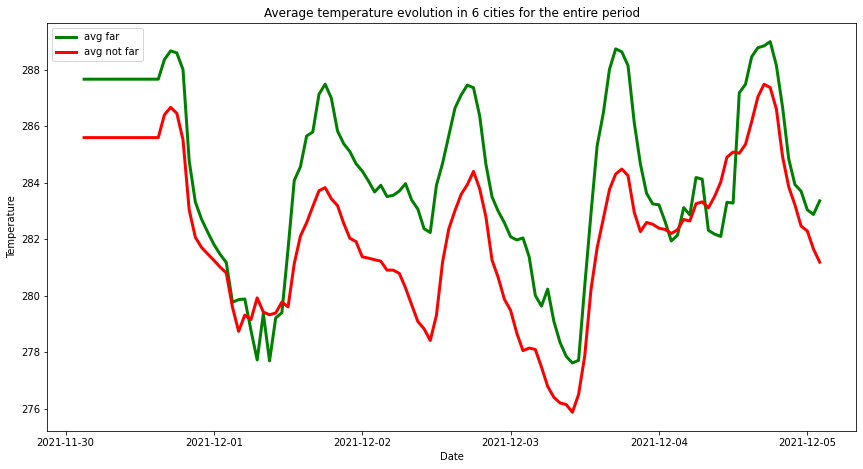

In [454]:
plt.plot(conc_df_far_cities['datetime'], conc_df_far_cities['temp'], color='green', label='avg far', linewidth=3.0)
plt.plot(conc_df_not_far_cities['datetime'], conc_df_not_far_cities['temp'], color='red', label='avg not far', linewidth=3.0)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Average temperature evolution in 6 cities for the entire period')

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

The resulting graph clearly shows that the average temperature in coastal cities is lower than in cities far from the ocean and our chosen city.

### 5.4. Deepen your analysis by correlating in a scatter plot (scatter plot) the relationship between the distance that separates the 10 cities from the sea and their maximum temperatures (obtained between the various collection days considered).

To complete this task, first add a column of distances from the selected main city. To do this, use the following code:

In [455]:
def label_race (row):
    return cities_info[row['city']]['distance']

    
weather_df['distance'] = weather_df.apply(lambda row: label_race(row), axis=1)

Calculate the maximum temperature for each city by day and build the corresponding graph:

In [456]:
weather_df['max_temp'] = weather_df.groupby([weather_df["city"], 
                                             weather_df["datetime"].dt.day])['temp'].transform('max')

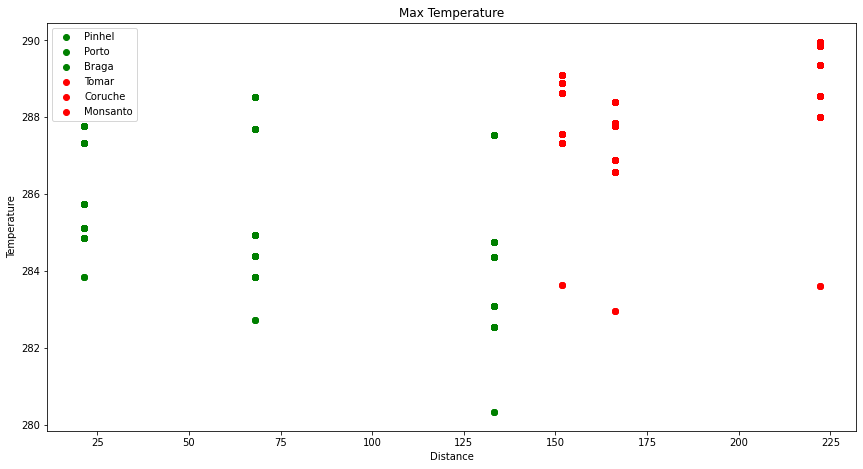

In [457]:
for city_name in not_far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    plt.scatter(weather_1day['distance'], weather_1day['max_temp'], color='green', label=city_name, linewidth=1.0)

for city_name in far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    plt.scatter(weather_1day['distance'], weather_1day['max_temp'], color='red', label=city_name, linewidth=1.0)

plt.xlabel('Distance')
plt.ylabel('Temperature')
plt.title('Max Temperature')

plt.legend()

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

We see that, on average, the <b>spread</b> of maximum temperatures is smaller in cities far from the ocean, but it is difficult to understand something else on such graph, let's calculate the average maximum humidity for each city for more illustrative results.

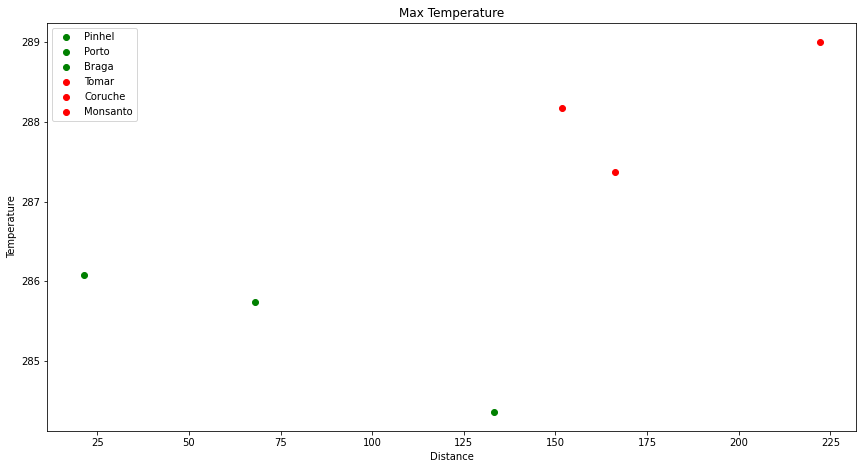

In [458]:
for city_name in not_far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    plt.scatter(weather_1day['distance'].mean(), weather_1day['max_temp'].mean(), color='green', label=city_name, linewidth=1.0)

for city_name in far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    plt.scatter(weather_1day['distance'].mean(), weather_1day['max_temp'].mean(), color='red', label=city_name, linewidth=1.0)

plt.xlabel('Distance')
plt.ylabel('Temperature')
plt.title('Max Temperature')

plt.legend()

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

here we can observe that maximum temperatures are on average higher in cities that far from Esmoriz.

### 5.5. Aprofunde a sua análise ao correlacionar num scatter plot (gráfico de dispersão) a relação entre a distância que separa as 10 cidades do mar e as suas temperaturas mínimas (obtidas entre os vários dias de coleta considerados).


Resort to similar actions to obtain a scattering diagram with minimum temperatures:

In [459]:
weather_df['min_temp'] = weather_df.groupby([weather_df["city"], 
                                             weather_df["datetime"].dt.day])['temp'].transform('min')

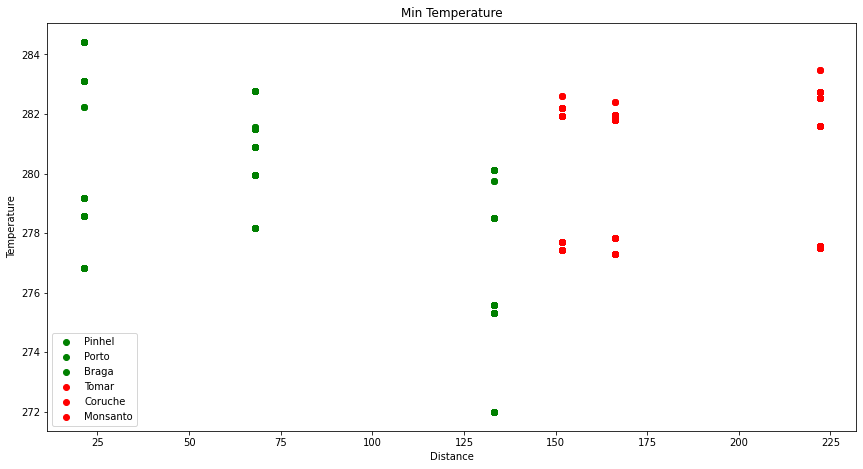

In [460]:
for city_name in not_far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    plt.scatter(weather_1day['distance'], weather_1day['min_temp'], color='green', label=city_name, linewidth=1.0)

for city_name in far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    plt.scatter(weather_1day['distance'], weather_1day['min_temp'], color='red', label=city_name, linewidth=1.0)

plt.xlabel('Distance')
plt.ylabel('Temperature')
plt.title('Min Temperature')

plt.legend()

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

According to this schedule, it is difficult to find any unambiguous conclusions. We can notice that the minimum temperatures in coastal cities do not differ much from the values in cities more remote from the ocean as we saw before.

 ###  5.6. Check the evolution of humidity on a given day in 6 cities of your choice. Since the objective is to analyze how and if the proximity to the sea influences the weather, you should start by choosing the 3 cities closest to the sea (in green in the example) and the 3 furthest away (in red in the example).

Plotting the dependence of humidity by time:

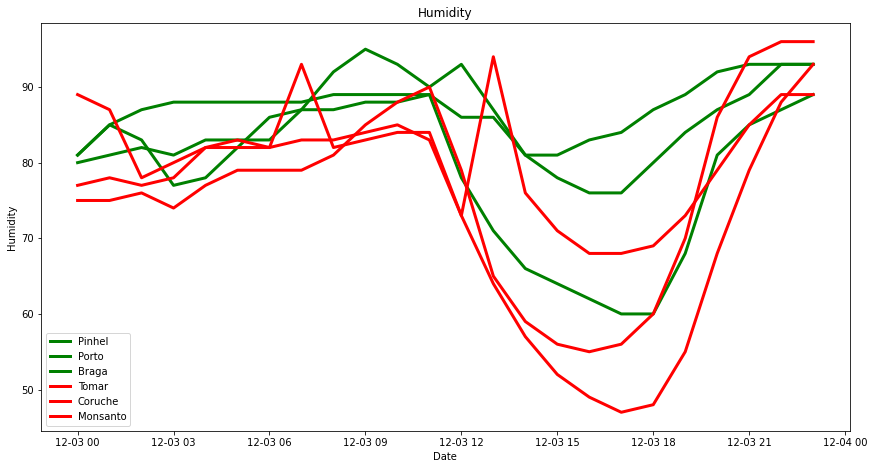

In [461]:
for city_name in not_far_from_main:
    weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == city_name)]
    plt.plot(weather_1day['datetime'], weather_1day['humidity'], color='green', label=city_name, linewidth=3.0)

for city_name in far_from_main:
    weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == city_name)]
    plt.plot(weather_1day['datetime'], weather_1day['humidity'], color='red', label=city_name, linewidth=3.0)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Humidity')
plt.title('Humidity')

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

The graph shows that the humidity in coastal cities is on average higher than in the rest in day and quite the similar in the night, which is not surprising, since they are closer to the water. The highest humidity is reached at night, the minimum - during the day around 4-6 p.m.

Also desided to see this graph for all 5 days for all these cities with the help of function that was written above.

In [462]:
conc_h_df_far_cities = calculate_average_temp(weather_df, far_from_main, 'humidity')
conc_h_df_not_far_cities = calculate_average_temp(weather_df, not_far_from_main, 'humidity')

Plot visualization:

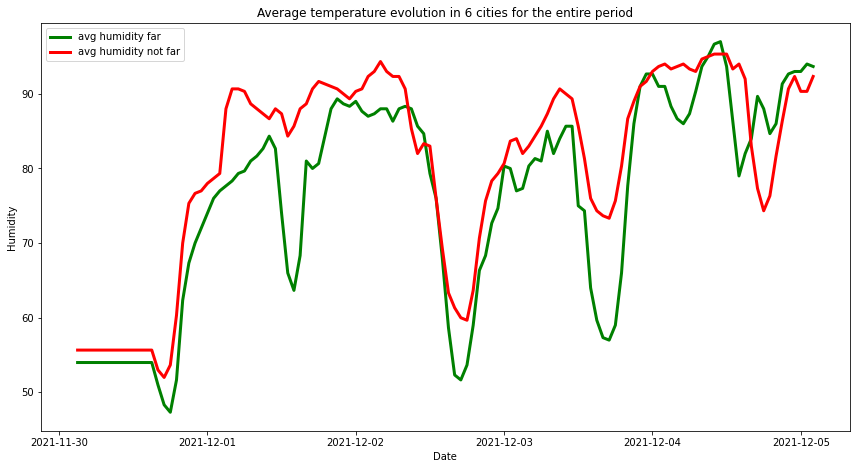

In [463]:
plt.plot(conc_h_df_far_cities['datetime'], conc_h_df_far_cities['humidity'], color='green', label='avg humidity far', linewidth=3.0)
plt.plot(conc_h_df_not_far_cities['datetime'], conc_h_df_not_far_cities['humidity'], color='red', label='avg humidity not far', linewidth=3.0)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Humidity')
plt.title('Average temperature evolution in 6 cities for the entire period')

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

As we can see the humidity is higher in coastal cities, which means that humidity is inversely correlated with temperature, this can be checked with the code below:

In [464]:
correlation = weather_df['humidity'].corr(weather_df['temp'])
correlation

-0.46365153557490896

Our hypothesis was confirmed.

### 5.7. Deepen your analysis by correlating in a scatter plot (scatter plot) the relationship between the distance that separates the 10 cities from the sea and the respective maximum and minimum humidity (obtained between the various collection days considered). Consider using the subplot functionality to show both graphs next to each other.

Let's calculate the maximum and minimum humidity for each city by day:

In [465]:
weather_df['max_humidity'] = weather_df.groupby([weather_df["city"], 
                                             weather_df["datetime"].dt.day])['humidity'].transform('max')

weather_df['min_humidity'] = weather_df.groupby([weather_df["city"], 
                                             weather_df["datetime"].dt.day])['humidity'].transform('min')

Look at the resulting data set:

In [466]:
weather_df.head()

,city,dt,humidity,pressure,description,wind_speed,wind_deg,temp,datetime,distance,max_temp,min_temp,max_humidity,min_humidity
0,Ponte de Sor,1638230400,56,1027,few clouds,2.11,98,286.96,2021-11-30 03:00:00,196.83,288.14,281.83,75,51
1,Ponte de Sor,1638234000,56,1027,few clouds,2.11,98,286.96,2021-11-30 04:00:00,196.83,288.14,281.83,75,51
2,Ponte de Sor,1638237600,56,1027,few clouds,2.11,98,286.96,2021-11-30 05:00:00,196.83,288.14,281.83,75,51
3,Ponte de Sor,1638241200,56,1027,few clouds,2.11,98,286.96,2021-11-30 06:00:00,196.83,288.14,281.83,75,51
4,Ponte de Sor,1638244800,56,1027,few clouds,2.11,98,286.96,2021-11-30 07:00:00,196.83,288.14,281.83,75,51


We proceed to the construction of a moisture scatter diagram for the selected 6 cities:

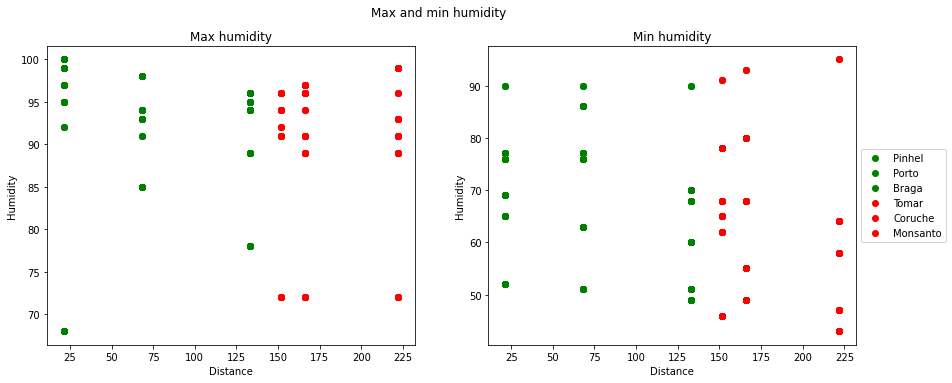

In [467]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Max and min humidity')


for city_name in not_far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    weather_1day = weather_1day
    ax1.scatter(weather_1day['distance'], weather_1day['max_humidity'], color='green', label=city_name, linewidth=1.0)

for city_name in far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    weather_1day = weather_1day
    ax1.scatter(weather_1day['distance'], weather_1day['max_humidity'], color='red', label=city_name, linewidth=1.0)

ax1.set(xlabel='Distance', ylabel='Humidity', title='Max humidity')


for city_name in not_far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    weather_1day = weather_1day
    ax2.scatter(weather_1day['distance'], weather_1day['min_humidity'], color='green', label=city_name, linewidth=1.0)

for city_name in far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    weather_1day = weather_1day
    ax2.scatter(weather_1day['distance'], weather_1day['min_humidity'], color='red', label=city_name, linewidth=1.0)

ax2.set(xlabel='Distance', ylabel='Humidity', title='Min humidity')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gcf().set_size_inches(14.5, 5.5)

plt.show()

From the graphs, we see that the max and min humidity looks quite the same in all cities. It is worth to do more research with the calculation average values of humidity.

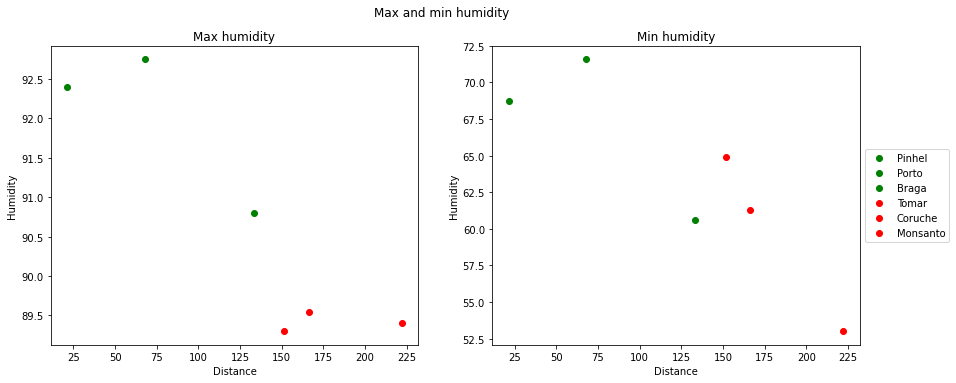

In [468]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Max and min humidity')


for city_name in not_far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    weather_1day = weather_1day
    ax1.scatter(weather_1day['distance'].mean(), weather_1day['max_humidity'].mean(), color='green', label=city_name, linewidth=1.0)

for city_name in far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    weather_1day = weather_1day
    ax1.scatter(weather_1day['distance'].mean(), weather_1day['max_humidity'].mean(), color='red', label=city_name, linewidth=1.0)

ax1.set(xlabel='Distance', ylabel='Humidity', title='Max humidity')


for city_name in not_far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    weather_1day = weather_1day
    ax2.scatter(weather_1day['distance'].mean(), weather_1day['min_humidity'].mean(), color='green', label=city_name, linewidth=1.0)

for city_name in far_from_main:
    weather_1day = weather_df[weather_df['city'] == city_name]
    weather_1day = weather_1day
    ax2.scatter(weather_1day['distance'].mean(), weather_1day['min_humidity'].mean(), color='red', label=city_name, linewidth=1.0)

ax2.set(xlabel='Distance', ylabel='Humidity', title='Min humidity')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gcf().set_size_inches(14.5, 5.5)

plt.show()

In this graph, we can see once again that the maximum humidity is higher in coastal cities, and the minimum humidity does not differ much.

I am interested what other parameters correlate with the remoteness of the city from the ocean. Let's look at the wind speed in a similar way:

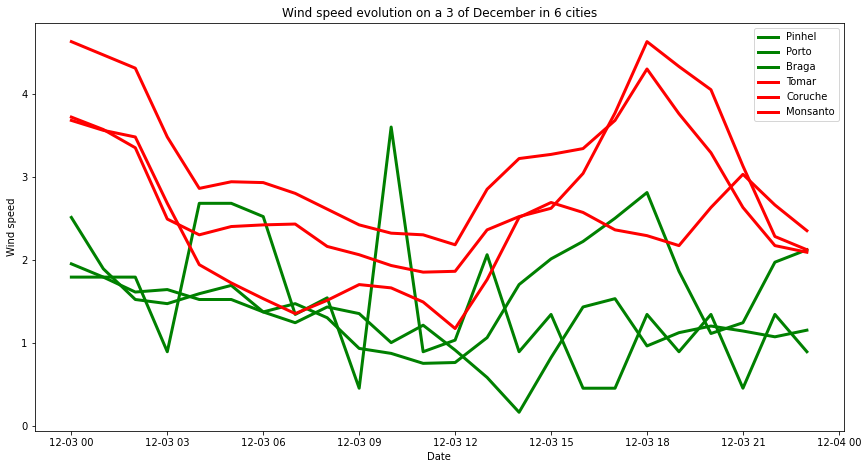

In [422]:
for city_name in not_far_from_main:
    weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == city_name)]
    plt.plot(weather_1day['datetime'], weather_1day['wind_speed'], color='green', label=city_name, linewidth=3.0)

for city_name in far_from_main:
    weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == city_name)]
    plt.plot(weather_1day['datetime'], weather_1day['wind_speed'], color='red', label=city_name, linewidth=3.0)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Wind speed')
plt.title('Wind speed evolution on a 3 of December in 6 cities')

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

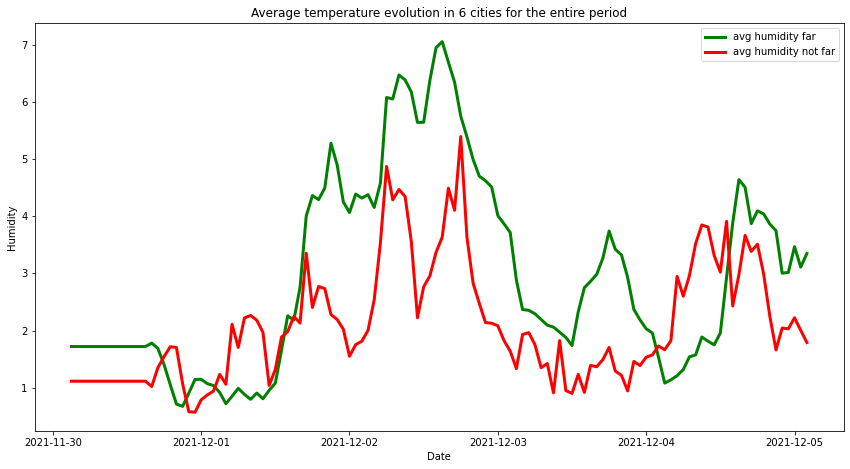

In [469]:
conc_ws_df_far_cities = calculate_average_temp(weather_df, far_from_main, 'wind_speed')
conc_ws_df_not_far_cities = calculate_average_temp(weather_df, not_far_from_main, 'wind_speed')

plt.plot(conc_ws_df_far_cities['datetime'], conc_ws_df_far_cities['wind_speed'], color='green', label='avg humidity far', linewidth=3.0)
plt.plot(conc_ws_df_not_far_cities['datetime'], conc_ws_df_not_far_cities['wind_speed'], color='red', label='avg humidity not far', linewidth=3.0)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Humidity')
plt.title('Average temperature evolution in 6 cities for the entire period')

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

Here we can clearly see that the wind speed is higher in cities far from the ocean, both at night and during the day and wind speed has little correlation with temperature. Check it below:

In [470]:
correlation = weather_df['wind_speed'].corr(weather_df['temp'])
correlation

0.23250615213386056

The conclusion was confirmed.

Moreover, we can look at how pressure affects the distance from the ocean. It is expected that there will be no significant impact, since the cities were chosen at approximately the same height from sea level.

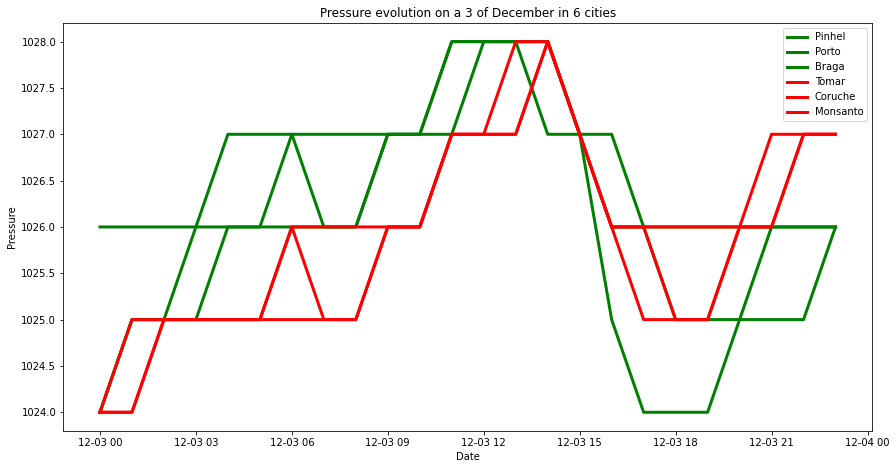

In [471]:
for city_name in not_far_from_main:
    weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == city_name)]
    plt.plot(weather_1day['datetime'], weather_1day['pressure'], color='green', label=city_name, linewidth=3.0)

for city_name in far_from_main:
    weather_1day = weather_df[(weather_df["datetime"].dt.day == 3) & (weather_df['city'] == city_name)]
    plt.plot(weather_1day['datetime'], weather_1day['pressure'], color='red', label=city_name, linewidth=3.0)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Pressure')
plt.title('Pressure evolution on a 3 of December in 6 cities')

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

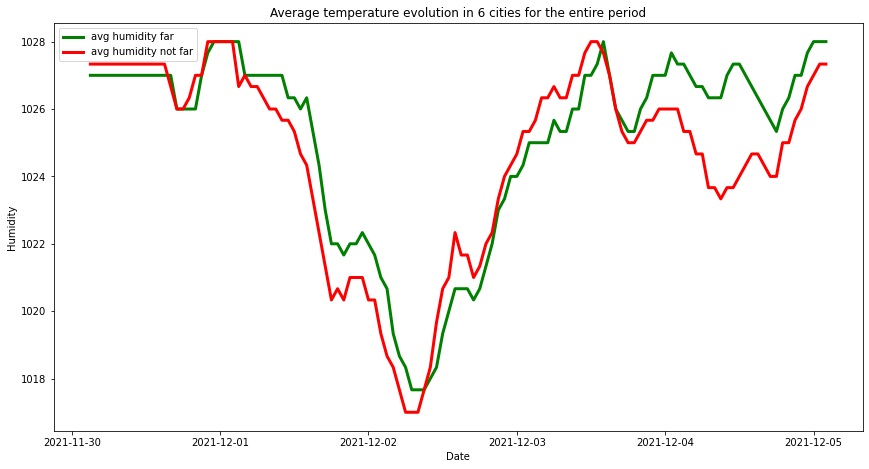

In [472]:
conc_pr_df_far_cities = calculate_average_temp(weather_df, far_from_main, 'pressure')
conc_pr_df_not_far_cities = calculate_average_temp(weather_df, not_far_from_main, 'pressure')

plt.plot(conc_pr_df_far_cities['datetime'], conc_pr_df_far_cities['pressure'], color='green', label='avg humidity far', linewidth=3.0)
plt.plot(conc_pr_df_not_far_cities['datetime'], conc_pr_df_not_far_cities['pressure'], color='red', label='avg humidity not far', linewidth=3.0)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Humidity')
plt.title('Average temperature evolution in 6 cities for the entire period')

plt.gcf().set_size_inches(14.5, 7.5)

plt.show()

Our expectations were confirmed, in this case it is really very difficult to catch any difference between the pressures, sometimes it's higher - sometimes lower. The difference may be due to the fact that the cities are located at an altitude of 90 to 150 m above sea level.

And since we have already started looking at correlations, let's build a correlation matrix for all features:

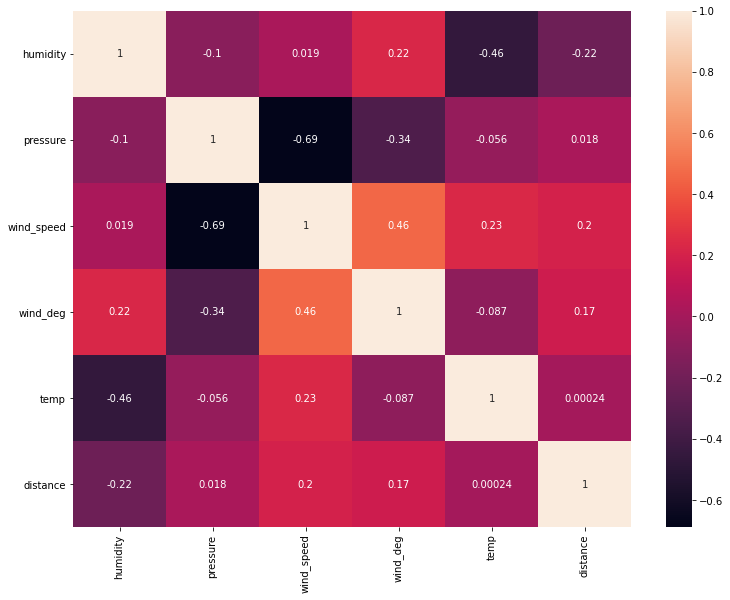

In [517]:
weather_corr_matrix = weather_df[['humidity', 'pressure', 'wind_speed', 'wind_deg', 'temp', 'distance']].corr()
sn.heatmap(weather_corr_matrix, annot=True)
plt.gcf().set_size_inches(12.5, 9.5)

plt.show()

In [524]:
from math import fabs

for i in range(len(weather_corr_matrix.columns)):
    for j in range(i+1, len(weather_corr_matrix.columns)):
        if fabs(weather_corr_matrix.iloc[i][j]) >= 0.4:
            print(f'Find correlation > 0.4 between {weather_corr_matrix.columns[i].upper()} and {weather_corr_matrix.columns[j].upper()}')

Find correlation > 0.4 between HUMIDITY and TEMP
Find correlation > 0.4 between PRESSURE and WIND_SPEED
Find correlation > 0.4 between WIND_SPEED and WIND_DEG


After visualizing the correlation matrix, we can notice that some parameters slightly correlate with the distance, but at the same time, temperature is the least correlated with the distance.

This is where we can finish this study. Judging by the results obtained, we can make a primary conclusion that the distance from the ocean really clearly affects the weather, which means it makes sense to try to use machine learning models to predict the weather in cities based on its remoteness from the ocean.